In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 0. IMPORT
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
# 1. LOAD TRAIN
train_path = "/content/drive/MyDrive/UTS ML & DL/Fraud Transaction/train_transaction.csv"
train_df = pd.read_csv(train_path)

print(train_df.shape)
train_df.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 2. PISAH TARGET & FITUR
target_col = "isFraud"

y = train_df[target_col]
X = train_df.drop(columns=[target_col])

# (opsional) pilih subset kolom biar nggak terlalu berat
selected_cols = [
    "TransactionID", "TransactionAmt", "ProductCD",
    "card4", "card6", "addr1", "dist1"
]
X = X[selected_cols]

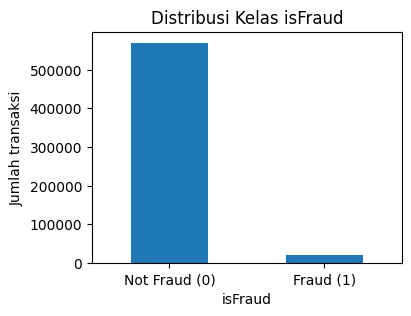

Proporsi fraud: 0.03499000914417313


In [10]:
# 2a. Visualisasi class imbalance isFraud
import matplotlib.pyplot as plt

fraud_counts = y.value_counts().sort_index()

plt.figure(figsize=(4,3))
fraud_counts.plot(kind="bar")
plt.xticks([0, 1], ["Not Fraud (0)", "Fraud (1)"], rotation=0)
plt.ylabel("Jumlah transaksi")
plt.title("Distribusi Kelas isFraud")
plt.show()

print("Proporsi fraud:", fraud_counts[1] / fraud_counts.sum())


In [11]:
# 3. TRAIN/VAL SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
# 4. PREPROCESSOR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer   # <- TAMBAHKAN INI

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Untuk fitur numerik: isi NaN dengan median, lalu scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Untuk fitur kategorik: isi NaN dengan kategori paling sering, lalu one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [13]:
# 5a. MODEL 1: LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=200,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]
)

log_reg.fit(X_train, y_train)

y_val_proba_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_pred_lr  = (y_val_proba_lr >= 0.5).astype(int)

print("AUC LR:", roc_auc_score(y_val, y_val_proba_lr))
print(classification_report(y_val, y_val_pred_lr))



AUC LR: 0.7384329075353511
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    113975
           1       0.08      0.61      0.14      4133

    accuracy                           0.75    118108
   macro avg       0.53      0.68      0.50    118108
weighted avg       0.95      0.75      0.83    118108



In [14]:
# 5b. MODEL 2: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=12,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_clf.fit(X_train, y_train)

y_val_proba_rf = rf_clf.predict_proba(X_val)[:, 1]
y_val_pred_rf  = (y_val_proba_rf >= 0.5).astype(int)

print("AUC RF:", roc_auc_score(y_val, y_val_proba_rf))
print(classification_report(y_val, y_val_pred_rf))

AUC RF: 0.8377158535505158
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.67      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108



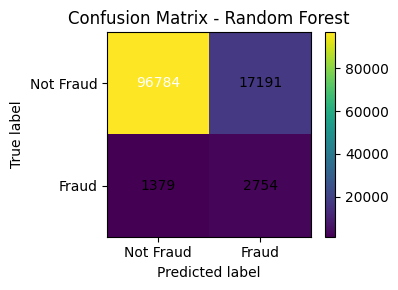

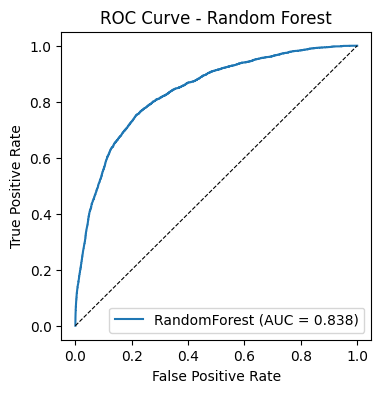

In [15]:
# 5b-visual. Confusion Matrix + ROC Random Forest
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - Random Forest")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["Not Fraud", "Fraud"])
plt.yticks(tick_marks, ["Not Fraud", "Fraud"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(4,4))
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], "k--", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


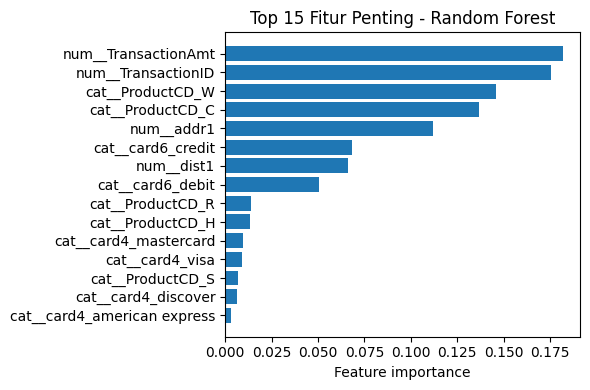

In [16]:
# 5b-feature. Feature importance Random Forest
pre = rf_clf.named_steps["preprocess"]
rf_model = rf_clf.named_steps["model"]

feature_names = pre.get_feature_names_out()
importances = rf_model.feature_importances_

idx = np.argsort(importances)[::-1][:15]   # 15 fitur teratas
top_features = feature_names[idx]
top_importances = importances[idx]

plt.figure(figsize=(6,4))
plt.barh(range(len(top_features)), top_importances[::-1])
plt.yticks(range(len(top_features)), top_features[::-1])
plt.xlabel("Feature importance")
plt.title("Top 15 Fitur Penting - Random Forest")
plt.tight_layout()
plt.show()


In [17]:
# 6. PREDIKSI UNTUK test_transaction.csv
test_path = "/content/drive/MyDrive/UTS ML & DL/Fraud Transaction/test_transaction.csv"
test_df = pd.read_csv(test_path)

X_test = test_df[selected_cols]   # sama seperti X_train tadi

y_test_proba = rf_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "TransactionID": test_df["TransactionID"],
    "isFraud": y_test_proba
})

submission.head()
submission.to_csv("submission_fraud_baseline.csv", index=False)


In [18]:
# 6.1. Preprocess data khusus untuk Deep Learning

X_train_dl = preprocessor.fit_transform(X_train)
X_val_dl   = preprocessor.transform(X_val)
X_test_dl  = preprocessor.transform(X_test)  # kalau kamu punya X_test untuk submission

# Ubah ke float32 biar lebih hemat dan match dengan TensorFlow
X_train_dl = X_train_dl.astype("float32")
X_val_dl   = X_val_dl.astype("float32")
X_test_dl  = X_test_dl.astype("float32")

X_train_dl.shape, X_val_dl.shape


((472432, 17), (118108, 17))

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
class_weight_dict


{np.int64(0): np.float64(0.5181288961224123),
 np.int64(1): np.float64(14.290139140955837)}

In [20]:
## 6. Deep Learning Model – Feedforward Neural Network (ANN)
input_dim = X_train_dl.shape[1]
input_dim
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # output probabilitas fraud
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
es = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_dl, y_train,
    validation_data=(X_val_dl, y_val),
    epochs=30,
    batch_size=4096,         # batch besar biar hemat RAM
    class_weight=class_weight_dict,
    callbacks=[es],
    verbose=1
)


Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - auc: 0.6759 - loss: 0.6428 - precision: 0.0626 - recall: 0.6051 - val_auc: 0.7539 - val_loss: 0.5819 - val_precision: 0.0843 - val_recall: 0.6526
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - auc: 0.7435 - loss: 0.5968 - precision: 0.0813 - recall: 0.6446 - val_auc: 0.7631 - val_loss: 0.5811 - val_precision: 0.0877 - val_recall: 0.6603
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - auc: 0.7523 - loss: 0.5892 - precision: 0.0836 - recall: 0.6526 - val_auc: 0.7679 - val_loss: 0.5765 - val_precision: 0.0889 - val_recall: 0.6630
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - auc: 0.7569 - loss: 0.5848 - precision: 0.0849 - recall: 0.6516 - val_auc: 0.7714 - val_loss: 0.5866 - val_precision: 0.0886 - val_recall: 0.6712
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - auc: 0.7603 - loss: 0.5815 - precision: 0.0858 - recall: 0.6544 - val_auc: 0.7735 - val_loss: 0.5777 - val_precision: 0.0899 - val_recall: 0.

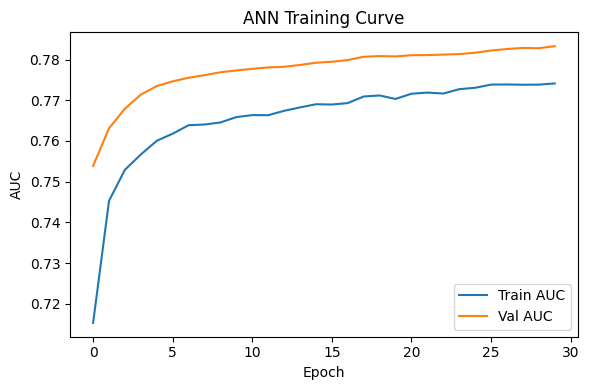

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("ANN Training Curve")
plt.legend()
plt.tight_layout()
plt.show()


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation AUC (Deep Learning): 0.7834

Classification Report (Deep Learning):
              precision    recall  f1-score   support

           0     0.9846    0.7683    0.8631    113975
           1     0.0946    0.6680    0.1658      4133

    accuracy                         0.7648    118108
   macro avg     0.5396    0.7182    0.5144    118108
weighted avg     0.9534    0.7648    0.8387    118108



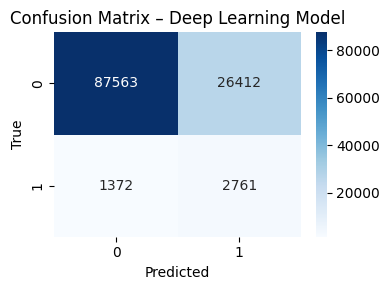

In [23]:
from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix
)
import seaborn as sns

# Prediksi probabilitas & label
y_val_proba_dl = model.predict(X_val_dl).ravel()
y_val_pred_dl  = (y_val_proba_dl >= 0.5).astype(int)

auc_dl = roc_auc_score(y_val, y_val_proba_dl)
print(f"Validation AUC (Deep Learning): {auc_dl:.4f}\n")

print("Classification Report (Deep Learning):")
print(classification_report(y_val, y_val_pred_dl, digits=4))

cm = confusion_matrix(y_val, y_val_pred_dl)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Deep Learning Model")
plt.tight_layout()
plt.show()


In [25]:
test_proba_dl = model.predict(X_test_dl).ravel()

submission_dl = pd.DataFrame({
    "TransactionID": test_df["TransactionID"],  # sesuaikan nama kolom
    "isFraud": test_proba_dl
})

submission_dl.head()
# submission_dl.to_csv("submission_dl.csv", index=False)


15835/15835 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


,TransactionID,isFraud
0,3663549,0.208893
1,3663550,0.278989
2,3663551,0.465687
3,3663552,0.376341
4,3663553,0.202657


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TransactionID'].plot(kind='hist', bins=20, title='TransactionID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['isFraud'].plot(kind='hist', bins=20, title='isFraud')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='TransactionID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='TransactionID', y='isFraud', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['isFraud']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('isFraud')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TransactionID']
  ys = series['isFraud']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('TransactionID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('isFraud')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TransactionID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TransactionID'}, axis=1)
              .sort_values('TransactionID', ascending=True))
  xs = counted['TransactionID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('TransactionID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['TransactionID'].plot(kind='line', figsize=(8, 4), title='TransactionID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['isFraud'].plot(kind='line', figsize=(8, 4), title='isFraud')
plt.gca().spines[['top', 'right']].set_visible(False)

## Summary – End-to-End Fraud Detection (ML + Deep Learning)

This end-to-end fraud detection pipeline includes:

1. **Data Loading & Merging**  
   - Menggunakan `train_transaction.csv` (+ optional identity table jika ada).  
   - Memisahkan label `isFraud` dan fitur-fitur transaksi.

2. **Preprocessing**  
   - Handling missing values dan tipe data.  
   - Pemisahan fitur numerik & kategorikal.  
   - `StandardScaler` untuk fitur numerik, `OneHotEncoder` untuk fitur kategorikal melalui `ColumnTransformer`.  

3. **Machine Learning Baseline**  
   - Model yang digunakan: Logistic Regression, Random Forest (sesuai notebook).  
   - Evaluasi dengan **ROC-AUC**, confusion matrix, dan classification report.  
   - Menjadi baseline performa untuk dibandingkan dengan Deep Learning.

4. **Deep Learning Model (ANN)**  
   - Menggunakan data yang telah dipreprocess (`preprocessor`) menjadi matriks fitur siap pakai.  
   - Arsitektur: Dense(128) + Dropout(0.3) → Dense(64) + Dropout(0.3) → Dense(1, sigmoid).  
   - Loss: **Binary Cross-Entropy**, Optimizer: **Adam**, Metrics: **AUC, Precision, Recall**.  
   - Menggunakan **class_weight** untuk menangani imbalance label fraud.  
   - **EarlyStopping** berdasarkan `val_auc` untuk mencegah overfitting.

5. **Evaluation & Comparison**  
   - Membandingkan **AUC** dan **Recall kelas fraud** antara:  
     - Logistic Regression / Random Forest (ML baseline).  
     - Deep Learning model (ANN).  
   - Menampilkan ROC curve, confusion matrix, dan classification report untuk memahami trade-off antara False Positive dan False Negative.

6. **Output**  
   - Menghasilkan probabilitas `isFraud` untuk data test.  
   - Menyusun file submission (`TransactionID`, `isFraud`) yang siap di-upload ke platform kompetisi / dinilai dosen.

**Key Takeaway:**  
- Pipeline ini menunjukkan bagaimana **model klasik (Scikit-Learn)** dan **model Deep Learning (Keras/TensorFlow)** dapat dibangun di atas **preprocessing yang sama**, lalu dievaluasi dengan metrik yang konsisten (ROC-AUC).  
- Untuk dataset ini, pemilihan model akhir bisa didasarkan pada kombinasi **AUC**, **Recall fraud**, serta kebutuhan bisnis (lebih takut miss fraud atau lebih takut false alarm).
